In [88]:
import os
import numpy as np
from numpy.linalg import eigvalsh
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, kron
from itertools import product, combinations
import plotly.graph_objects as go
from scipy.linalg import expm, sinm, cosm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})  # Change 12 to the desired font size
# Enable LaTeX rendering in Matplotlib
plt.rc('text', usetex=True)
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.set_printoptions(edgeitems=10)  # Set the number of elements at the beginning and end of each dimension when repr is called
np.set_printoptions(threshold=1000)  # Set the total number of array elements which trigger summarization rather than full repr
np.set_printoptions(precision=4)  # Set the precision for floating point output

ar = np.array
kr = np.kron
T = np.transpose

from MDS import *

pauli_z=ar([[1,0],[0,-1]])
pauli_y=ar([[0,-1j],[1j,0]])
pauli_x=ar([[0,1],[1,0]])

import warnings
warnings.filterwarnings('ignore')

mds_from_d_3D = MDS(3,dissimilarity='euclidean')
mds_from_d_2D = MDS(2,dissimilarity='euclidean')


<h3>The goal is to implement a function that does MDS using the coupling strength of the approximate 2-local form found for an initial Hamiltonian.<h3>

At first all parts of the MDS process are exposed. Then I put it all in one function


We start with loading the couplings and defining the total coupling strength table by summing the contributions from different interactions.

We also look at the coupling graph and create a re-scaled graph.

The $Jab$ matrix is expressed as a colored graph. We then create $w$ which is $-\log(J_{ab}/max_{ab}(J_{ab}))$. It weights couplings such that two vertices have high edge weight if they have low coupling strengh and vice versa. The log and renomalizing by the max(Jab) means we have 2 points with 0 distance by definition. The choice of function for re-weighting is already loaded with intent.



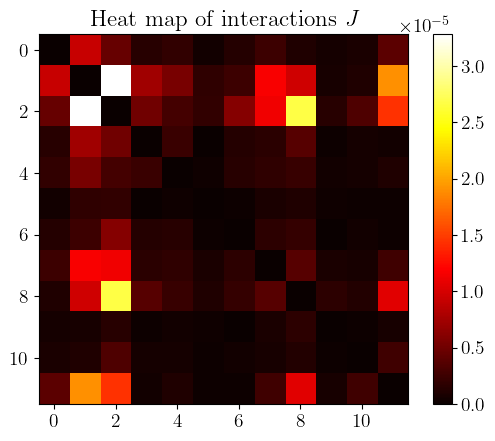

In [100]:
def get_Jab():

    N = 12 # system size
    k = 150 # sample number
    letters = ['1', 'X', 'Y', 'Z']

    J = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[1], letters[3]))**2
    for a,b in [(1,1),(2,2),(3,3),(3,1)]:
        Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))**2
        J+=Jab

    #threshold = 1e-4  # Set this to the threshold you want to use
    #Jab[np.abs(Jab) < threshold] = 0
    Jab=J
    return Jab

def get_Jab_avg(sample_nb):
    N = 12 # system size
    letters = ['1', 'X', 'Y', 'Z']

    J=np.zeros((N,N))
    for k in range(sample_nb):    
        J_sample = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[1], letters[3]))**2
        for a,b in [(1,1),(2,2),(3,3),(3,1)]:
            Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))**2
            #Jab = Jab**2
            J_sample+=Jab
        J+=J_sample
    J=J/sample_nb
    return J

def get_Jab_squared(k):
    N = 12 # system size
    letters = ['1', 'X', 'Y', 'Z']

    J=np.zeros((N,N))

    J_sample = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[1], letters[3]))**2
    for a,b in [(1,1),(2,2),(3,3),(3,1)]:
        Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))**2
        J_sample+=Jab
    return J_sample

k=0
Jab=get_Jab_squared(k)

plt.imshow(Jab, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Heat map of interactions $J$")
# Save the figure
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(os.path.join(output_dir, f'heatmap_Jsquared_{k}.png'))
plt.show()




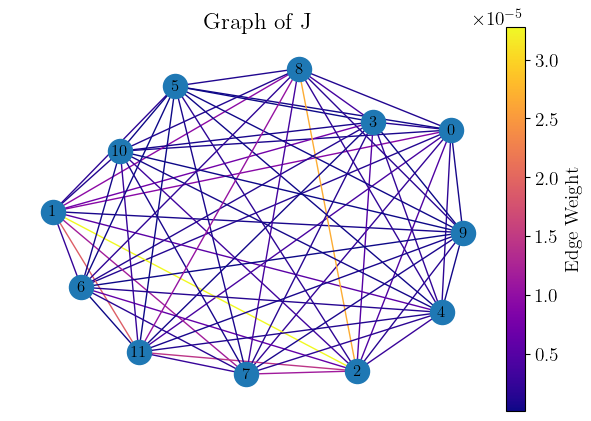

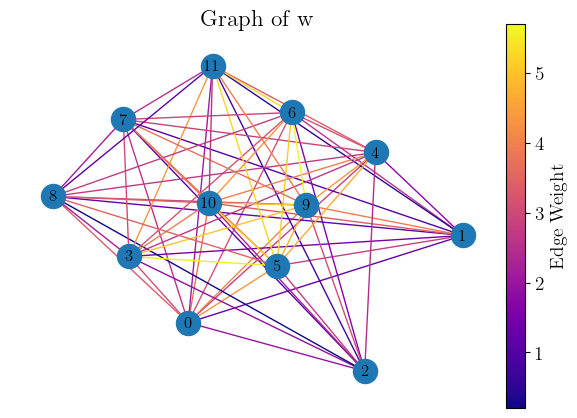

In [101]:


def define_graph(Jab,plot_name="no_name"):
    # Create a graph from Jab
    G = nx.from_numpy_array(Jab)

    edge_colors = [float(e[2]['weight']) for e in G.edges(data=True)]
    cmap = plt.cm.plasma  # You can choose any colormap you prefer

    # Create figure and axes
    fig, ax = plt.subplots()

    # Draw the graph with edge colors based on weight
    nx.draw(G, with_labels=True, edge_cmap=cmap, edge_color=edge_colors, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), ax=ax)

    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    fig.colorbar(sm, cax=cbar_ax, label='Edge Weight')
    ax.set_title(f"Graph of {plot_name}")
    # Save the figure
    output_dir = 'plots'
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
    plt.savefig(os.path.join(output_dir, f'graph_{plot_name}.png'))

    plt.show()

define_graph(Jab,"J")

def re_weighing(Jab):
    #Define the matrix w which has weights such that closer points have lower weight.
    N=Jab.shape[0]
    J_0=np.max(Jab)
    Jab=Jab/J_0
    w=np.zeros((N,N))
    for i in range(0,N):
        for j in range(i+1,N):
            #w[i,j]=1/((Jab[i,j]+1e-6))^2
            w[i,j]=-np.log(Jab[i,j]) 
            w[j,i]=w[i,j]
    return w
w=re_weighing(Jab)
define_graph(w,"w")


For the distance function, we do the same as in the paper by Charles and Carroll $$d(a,b)=min_P(\sum_{i} w(p_i,p_{i+1}))$$ 

Here we have a function to find all paths of length < l  that go from a verte to another. Then we feed this to another function that calculates the total weight of that path. We use this to define the distance.

In [91]:
import numpy as np


def find_all_paths(w, start_vertex, end_vertex, l, path=[]):
    path = path + [start_vertex]
    if start_vertex == end_vertex or len(path) == l:
        if path[-1] == end_vertex:  # Only consider paths that end at the end_vertex
            return [(path)] #return [(path, weight)]
        else:
            return []
    paths = []
    for node in range(w.shape[0]):
        if node not in path:
            newpaths = find_all_paths(w, node, end_vertex, l, path)
            for newpath in newpaths:
                paths.append(newpath)
    
    return paths

def calculate_path_weight(w, path):
    total_weight = 0
    for i in range(len(path) - 1):
        start_vertex = path[i]
        end_vertex = path[i+1]
        total_weight += w[start_vertex][end_vertex]
    return total_weight

def distance(w):
    dab=w
    for a in range(dab.shape[0]):
        for b in range(dab.shape[1]):
            weights = [calculate_path_weight(w, path) for path in find_all_paths(w, a, b, 5)]
            if a==b:
                dab[a][b]=0
            else:
                dab[a][b]=min(weights)
    return dab

# Specify the start and end vertices
#start_vertex = 0
#end_vertex = 2
#all_paths = find_all_paths(Jab, start_vertex, end_vertex,3)
#for path in all_paths:
#    print(f"Path: {path}")

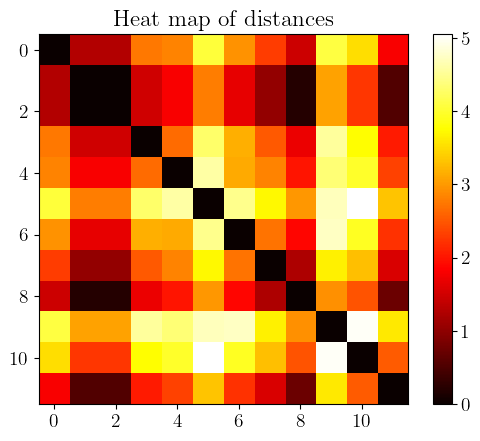

In [92]:
dab=distance(w)
plt.imshow(dab, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Heat map of distances")
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(os.path.join(output_dir, f'heatmap_distance_{k}.png'))
plt.show()



We now ask weather this graph with a distance defined on it approximates a smooth manifold of dim D

We take the MDS approach, and follow a procedure to embedd a graph with distance into a Euclidean manifold.
We again follow the paper and define matrix B,
$$B_{pq}=-\frac{1}{2}(d(p,q)^2-\frac{1}{N}\sum^{N}_{l=1}d(p,l)^2-\frac{1}{N}\sum^{N}_{l=1}d(l,q)^2+\frac{1}{N^2}\sum^N_{l,m=1}d(l,m)^2)$$

From $B$ we contruct $X$
$$X=(\sqrt{\lambda_1}v_1,\sqrt{\lambda_2}v_2...)$$

Note, I took the absolute values of eigenvalues

In [93]:
def calculate_B(dab):
    N = len(dab)
    B = [[0 for _ in range(N)] for _ in range(N)]
    
    for p in range(N):
        for q in range(N):
            if p == q:
                continue
            d_pq = dab[p][q]
            d_p_sum = sum([dab[p][l]**2 for l in range(N)])
            d_q_sum = sum([dab[l][q]**2 for l in range(N)])
            d_sum = sum([dab[l][m]**2 for l in range(N) for m in range(N)])
            B[p][q] = -0.5 * (d_pq**2 - (d_p_sum + d_q_sum) / N + d_sum / (N**2))
    return B

def calculate_X(B):
    N = np.shape(B)[0]
    X = np.zeros((N, N))

    eigenvalues, eigenvectors = np.linalg.eig(B)
    #TODO should I keep the negative eigenvalues?
    #eigenvalues=abs(eigenvalues)
    eigenvalues=eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    for i in range(N):
        X[:, i] = np.sqrt(eigenvalues[i]) * eigenvectors[:, i]
    return X

def eigenvalues(B):
    eigenvalues, _ = np.linalg.eig(B)
    eigenvalues=eigenvalues
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    return eigenvalues


We plot the eigenvalues in descending order so as to get an idea for the dominant dimensions.

Problem, we cant take abs values of eigenvalues. essentially, if B has negative eigenvalues we cant use classical MDS to find X. So i introduce an off the shelf solution.

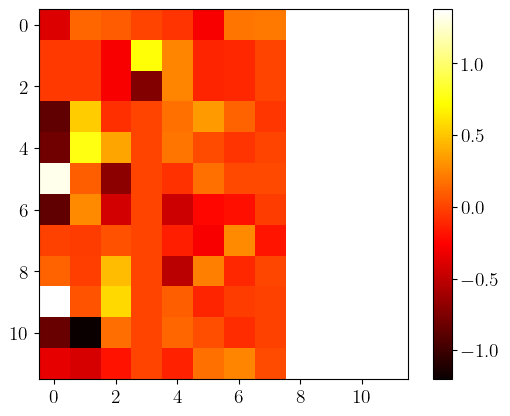

[ 6.7599  2.5932  1.5937  1.0734  0.7515  0.4796  0.2779  0.0798 -0.1657
 -1.6965 -2.0745 -9.6722]


Text(0.5, 1.0, 'Scatter plot of eigenvalues')

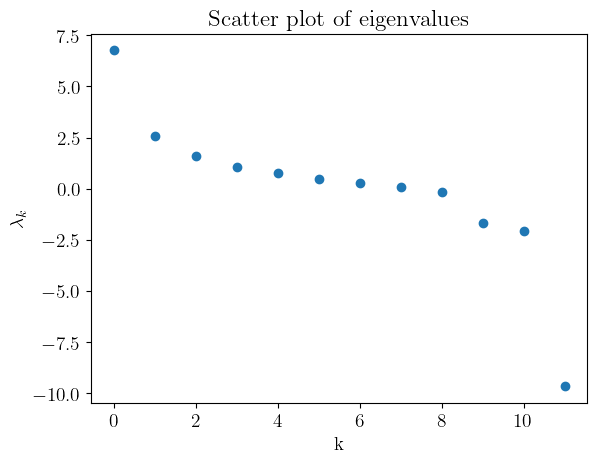

In [94]:
Bab=calculate_B(dab)
eig=eigenvalues(Bab)
Xab=calculate_X(Bab)

plt.imshow(Xab, cmap='hot', interpolation='nearest')
plt.colorbar()
#plt.title(f"Heat map of distances")
#output_dir = 'plots'
#os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
#plt.savefig(os.path.join(output_dir, f'heatmap_distance_{k}.png'))
plt.show()
print(eig)

plt.scatter(range(len(eig)),eig)
plt.ylabel(f'$\lambda_k$')
plt.xlabel("k")
plt.title("Scatter plot of eigenvalues")


In [95]:
def sphereFit(spX,spY,spZ):
    #   Assemble the A matrix
    spX = np.array(spX)
    spY = np.array(spY)
    spZ = np.array(spZ)
    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, residules, rank, singval = np.linalg.lstsq(A,f)

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = math.sqrt(t)

    # Calculate the residuals
    fittedX = C[0]
    fittedY = C[1]
    fittedZ = C[2]
    fitted_radius = radius

    residuals = np.sqrt((spX - fittedX)**2 + (spY - fittedY)**2 + (spZ - fittedZ)**2) - fitted_radius
    rmse = np.sqrt(np.mean(residuals**2))

    return radius, C[0], C[1], C[2], rmse

#Another simple way to compare them would be to see what the number of points in a sphere half the radius is.

def count_points_in_sphere(X, Y, Z, radius):
    # Convert X, Y, Z to numpy arrays if they are not already
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)
    
    # Calculate the distance from the origin for each point
    distances = np.sqrt(X**2 + Y**2 + Z**2)
    # Count how many distances are less than or equal to the radius
    count = np.sum(distances <= radius)
    
    return count


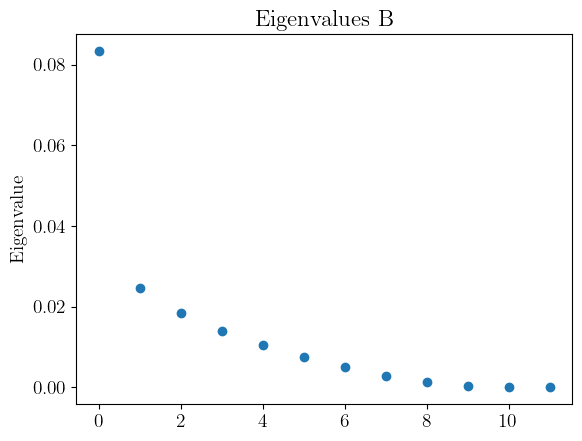

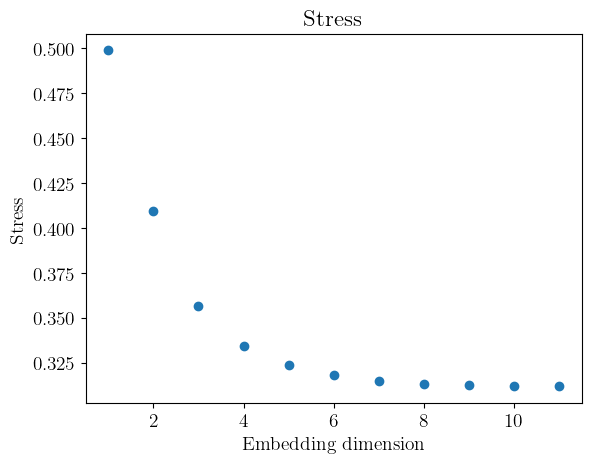

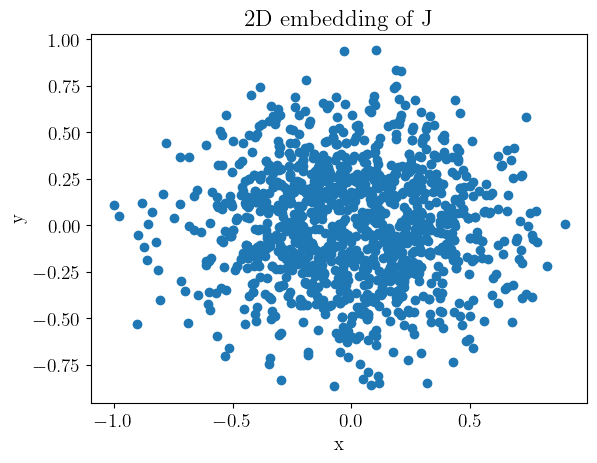

Number of points 1200
RMSE of the cloud points to a sphere: 
0.18640627285927827
Number of points in a sphere of radius 0.5: 


702

In [104]:

N=12
range_k=100

X3_long=[]
X2_long=[]
m_list=[]
m1_list=[]
eigen_avg=np.zeros(N)
stress_avg=np.zeros(N-1)
for k in range(range_k):
    Jab=get_Jab_squared(k)
    w=re_weighing(Jab)
    dab=distance(w)
    X2,X3,m1,m=mapData(dab,False)
    X3_long.append(X3)
    X2_long.append(X2)
    m_list.append(m)
    m1_list.append(m1)
    stress_avg+=get_stress(dab,False)
    eigen_avg+=get_eigenvalues_B_from_dab(dab,N,"tempoooo",False)
X3_long_array=np.concatenate(X3_long, axis=0)
X2_long_array=np.concatenate(X2_long, axis=0)
eigen_avg=eigen_avg/(N*max(eigen_avg))
stress_avg=stress_avg/(range_k)

plt.scatter(range(len(eigen_avg)),eigen_avg)
plt.title("Eigenvalues B")
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(os.path.join(output_dir, f'plot_eigenvalues_MDS_J_avg.png'))
plt.ylabel("Eigenvalue")
plt.show()

plt.scatter(range(1,len(stress_avg)+1),stress_avg)
plt.title("Stress")
plt.xlabel("Embedding dimension")
plt.ylabel("Stress")
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(os.path.join(output_dir, f'plot_stress_MDS_I_avg.png'))
plt.show()

m=max(m_list)
m1=max(m1_list)

plt.scatter(X2_long_array[:,0]/m1,X2_long_array[:,1]/m1)
plt.title("2D embedding of J")
plt.xlabel("x")
plt.ylabel("y")
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(os.path.join(output_dir, f'2D_embedding_J_avg.png'))
plt.show()

fig = go.Figure(data=go.Scatter3d(x=X3_long_array[:, 0]/m, y=X3_long_array[:, 1]/m, z=X3_long_array[:, 2]/m, mode='markers',marker=dict(size=2)))

fig.update_layout(
scene=dict(
            xaxis=dict(range=[-1, 1]),
            yaxis=dict(range=[-1, 1]),
            zaxis=dict(range=[-1, 1]),
            aspectmode='cube'))
        
fig.show()


r,x0,y0,z0, rmse=sphereFit(X3_long_array[:,0]/m,X3_long_array[:,1]/m,X3_long_array[:,2]/m)
print(f"Number of points {range_k*12}")
print("RMSE of the cloud points to a sphere: ")
print(rmse)
print("Number of points in a sphere of radius 0.5: ")
count_points_in_sphere(X3_long_array[:,0]/m, X3_long_array[:,1]/m, X3_long_array[:,2]/m, 0.5)

X is our coordinate matrix, we use it to calculate euclidean distances

We need an X defined for a D dimensional space. To get it, we use the scatter plot of eigenvalues and cut-off the relavant non-dominant columns of X.

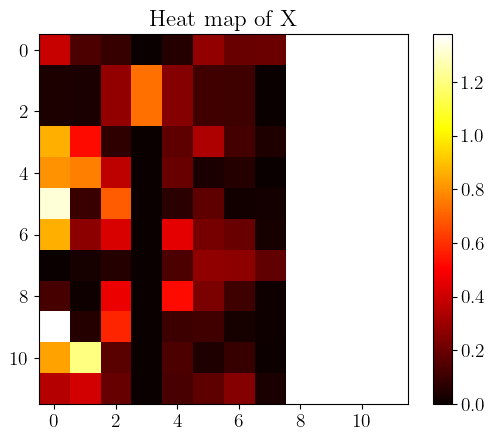

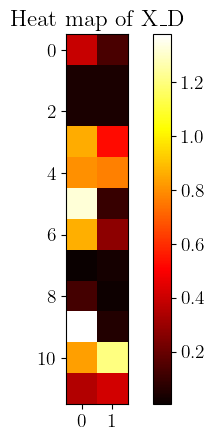

In [97]:
def get_X_D(X,D):
    #We defined here X but only with the first D columns.
    N=np.shape(X)[0]
    if D > N:
        raise ValueError("D exceeds the number of columns in X.")
    X_D = X[:, :D]
    return X_D

D = 2
X_D=get_X_D(Xab,D)

plt.imshow(abs(Xab), cmap='hot', interpolation='nearest')
plt.title("Heat map of X")
plt.colorbar()
plt.show()

plt.imshow(abs(X_D), cmap='hot', interpolation='nearest')
plt.title("Heat map of X_D")
plt.colorbar()
plt.show()


From X_D we can define the euclidean distance between the points in out D dimensional space $d_e(p,q)=\sqrt{\sum^D_{r=1}(X_{pr}-X_{qr})^2}$


In [98]:
def euclidean_distance(X):
    N, D = X.shape
    d_e = np.zeros((N, N))

    for p in range(N):
        for q in range(p+1, N):
            diff = X[p] - X[q]
            d_e[p, q] = np.sqrt(np.sum(diff**2))
            d_e[q, p] = d_e[p, q]
    return d_e

In [99]:
d_e=euclidean_distance(X_D)

We can now introduce the stress function, a way to estimate distortion necessary to embedd our graph in our D dim space.
$$stress=\sqrt{\frac{(\sum_{p,q}d(p,q)d_e(p,q))^2}{(\sum_{p,q}d(p,q))^2(\sum_{p,q}d_e(p,q))^2}}$$

Or we can use 
$$\epsilon_D=1-\frac{\sum^D_i\lambda_i}{\sum^N_i\lambda_i}$$

The smaller the better.